In [11]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [12]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [13]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [14]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [15]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)
# reflect the tables


/var/folders/cg/72yw7y6n4wxb3jgxj33txbt40000gn/T/ipykernel_94340/3559592862.py:3: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [16]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [17]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [18]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [19]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print(f"Most recent date in the dataset: {most_recent_date}")


Most recent date in the dataset: 2017-08-23


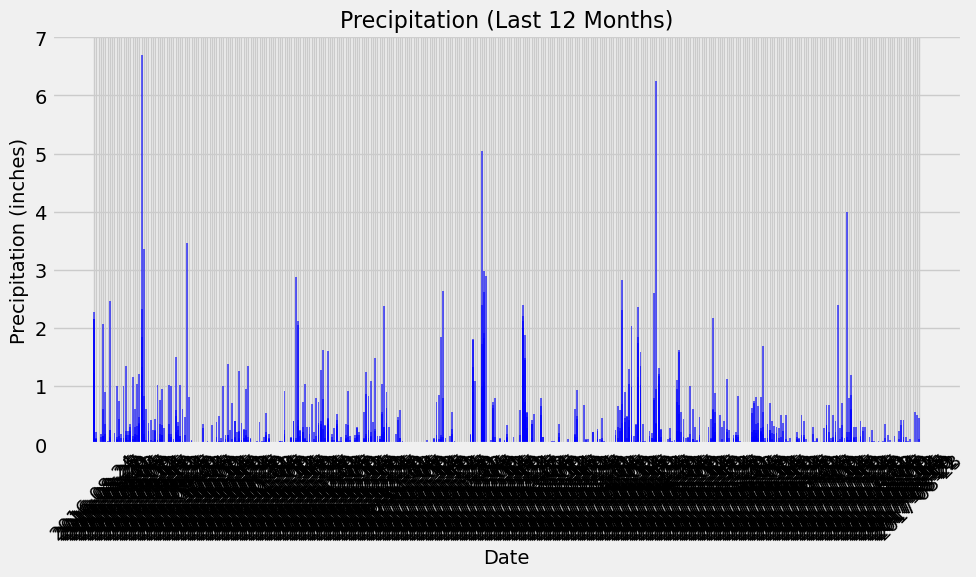

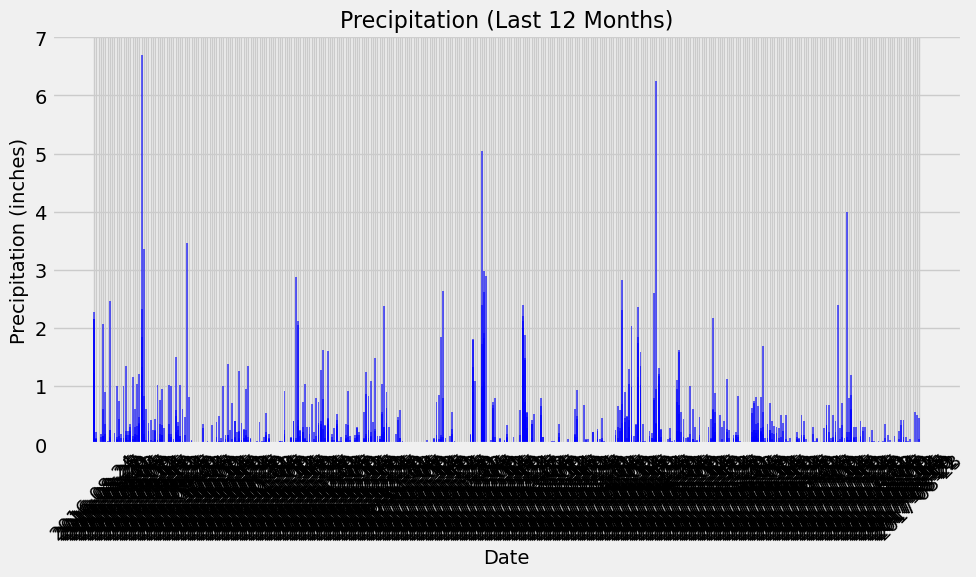

In [20]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
one_year_ago = dt.datetime.strptime(most_recent_date, "%Y-%m-%d") - dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores
precipitation_data = (
    session.query(Measurement.date, Measurement.prcp)
    .filter(Measurement.date >= one_year_ago)
    .order_by(Measurement.date)
    .all()
)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=["Date", "Precipitation"])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values("Date")


# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.bar(precipitation_df["Date"], precipitation_df["Precipitation"], color="b", alpha=0.6, align="center")
plt.title("Precipitation (Last 12 Months)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Precipitation (inches)", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


In [21]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_summary = precipitation_df.describe()
print(precipitation_summary)

       Precipitation
count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


# Exploratory Station Analysis

In [22]:
# Design a query to calculate the total number of stations in the dataset
active_stations = (
    session.query(Measurement.station, func.count(Measurement.station))
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.station).desc())
    .all()
    )
print("Most active stations (Station ID and Count):")
print(active_stations)


Most active stations (Station ID and Count):
[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [23]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
# Create a session
session = Session(engine)

# Step 1: Perform a query to count the rows per station
station_counts = (
    session.query(Measurement.station, func.count(Measurement.station))
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.station).desc())
    .all()
)

# Display the results
print("Most Active Stations (Ordered by Row Count):")
for station, count in station_counts:
    print(f"Station: {station}, Count: {count}")

Most Active Stations (Ordered by Row Count):
Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [24]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]
temp_stats = (
    session.query(
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs)
    )
    .filter(Measurement.station == most_active_station)
    .all()
)
print(f"Temperature stats for the most active station ({most_active_station}):")
print(f"Lowest Temperature: {temp_stats[0][0]}")
print(f"Highest Temperature: {temp_stats[0][1]}")
print(f"Average Temperature: {temp_stats[0][2]:.2f}")


Temperature stats for the most active station (USC00519281):
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66


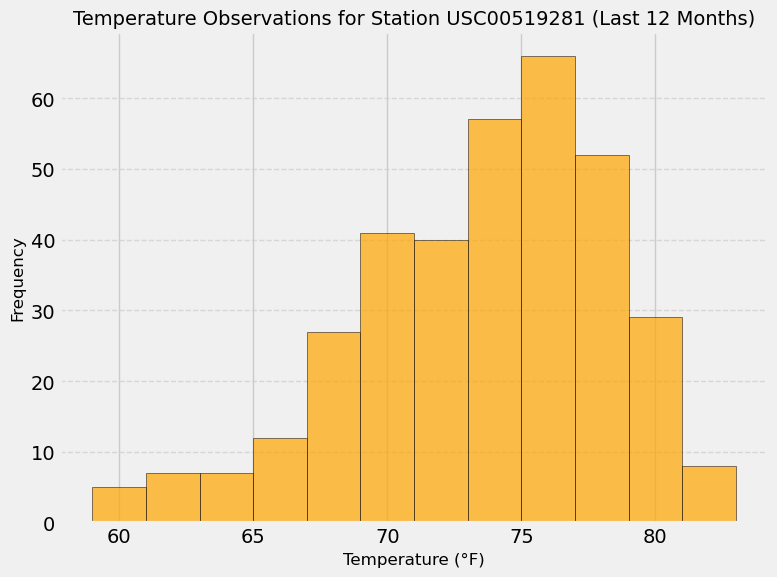

In [25]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station = station_counts[0][0]

#Query the last 12 months of temperature observation data for this station
temp_data = (
    session.query(Measurement.tobs)
    .filter(Measurement.station == most_active_station)
    .filter(Measurement.date >= one_year_ago)
    .all()
)

#Convert the query result to a list of temperatures
temp_stats = [temp[0] for temp in temp_data] 

#Create the histogeam plot
plt.figure(figsize=(8, 6))
plt.hist(temp_stats, bins=12, color="orange", edgecolor="black", alpha=0.7)
plt.title(f"Temperature Observations for Station {most_active_station} (Last 12 Months)", fontsize=14)
plt.xlabel("Temperature (°F)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()


plt.show()


# Close Session

In [26]:
# Close Session
session.close()